In [24]:
import matplotlib.pyplot as plt
import numpy as np
import math
import cv2

In [28]:
def calculate_filter_size_gradient(filter_size, sigma):

    mask_half = np.round(np.sqrt(- math.log(filter_size) * 2 * sigma**2))
    #print(mask_half)

    y, x = np.meshgrid((-mask_half, mask_half+1), (-mask_half , mask_half+1))

    print(type(x))
    #print(y)
    #print('----')
    #print(x)
    exponential = np.exp(- (x**2 + y**2) / 2 * sigma**2)
    print(exponential)
    gx = -(x / sigma**2) * exponential
    #print(gx)
    Gx = np.round(gx*255)
    print(Gx)
    print('================================')
    gy = -(y / sigma**2) * exponential
    #print(gy)
    Gy = np.round(gy*255)
    print(Gy)

    return Gx, Gy

In [29]:
def fx_fy_gradient(Gx, Gy, gray_image):
    x_range = abs(Gx.shape[1] - gray_image.shape[1])
    x_range
    y_range = abs(Gy.shape[0] - gray_image.shape[0])
    y_range
    
    fx = np.zeros((y_range, x_range))
    fy = np.zeros((y_range, x_range))
    
    for j in range(y_range):
        for i in range(x_range):
            fx[j,i] = np.sum(Gx* gray_image[j:Gx.shape[0]+j, i:Gx.shape[1]+i])
            
            
    for j in range(y_range):
        for i in range(x_range):
            fy[j,i] = np.sum(Gy* gray_image[j:Gy.shape[0]+j, i:Gy.shape[1]+i])
            
    return fx, fy

In [30]:
def magnitude(fx, fy):
    #computing the gradient magnitude

    magnitude = np.sqrt(np.square(fx) + np.square(fy))
    magnitude = (magnitude/255)
    return magnitude

In [31]:
def direction(fx, fy):
    #computing the gradient direction
    theta = np.arctan2(fy, fx)
    print(theta)
    angles = np.rad2deg(theta) + 180
    print(angles)
    
    return angles

In [32]:
def quantization(magnitude, angles):
    quantized_magnitudes = np.zeros((magnitude.shape)) #creating an array equal to size of magnitude array

    for i in range(magnitude.shape[0]-1):
        for j in range(magnitude.shape[1]-1):
            if (0 <= angles[i,j] <=22.5) or (157.5 <= angles[i,j] <=202.5) or (337.5 <= angles[i,j] <=360):

                    quantized_magnitudes[i,j] = 0
            elif (22.5 <= angles[i,j] <= 67.5) or (202.5 <= angles[i,j] <= 247.5):

                    quantized_magnitudes[i,j] = 1

            elif (67.5 <= angles[i,j] <= 112.5) or (247.5 <= angles[i,j] <= 292.5):

                    quantized_magnitudes[i,j] = 2

            elif (112.5 <= angles[i,j] <= 157.5) or (292.5 <= angles[i,j] <= 337.5):

                    quantized_magnitudes[i,j] = 3
                    
    return quantized_magnitudes


def colored_quantization(mat, magnitude):
    colored_magnitudes = np.zeros((magnitude.shape[0],magnitude.shape[1],3)) #creating an array equal to size of magnitude array

    for i in range(magnitude.shape[0]-1):
        for j in range(magnitude.shape[1]-1):
            if mat[i,j] == 0:
                if magnitude[i,j] != 0:
                        colored_magnitudes[i,j,0] = 100
                else:
                        colored_magnitudes[i,j,0] =0

            if mat[i,j] == 1:
                if magnitude[i,j] != 0:
                        colored_magnitudes[i,j,1] = 100
                else:
                        colored_magnitudes[i,j,1] =0 

            if mat[i,j] == 2:
                if magnitude[i,j] != 0:
                        colored_magnitudes[i,j,2] = 100
                else:
                        colored_magnitudes[i,j,2] =0

            if mat[i,j] == 3:
                if magnitude[i,j] != 0:
                        colored_magnitudes[i,j,0] = 100
                        colored_magnitudes[i,j,1] = 100
                        
                else:
                        colored_magnitudes[i,j,0] =0
                        colored_magnitudes[i,j,1] =0

    return colored_magnitudes    

In [33]:
def non_max_supression(magnitude, quantized_magnitudes):
    magnitudes = np.zeros((magnitude.shape))

    for i in range(magnitude.shape[0]-1):
        for j in range(magnitude.shape[1]-1):
            if quantized_magnitudes[i,j] == 0:
                if (magnitude[i,j] > magnitude[i, j-1]) and (magnitude[i,j] > magnitude[i, j+1]):
                    magnitudes[i,j] = magnitude[i,j]
            elif quantized_magnitudes[i,j] == 1:
                if (magnitude[i,j] > magnitude[i-1, j]) and (magnitude[i,j] > magnitude[i+1, j]):
                    magnitudes[i,j] = magnitude[i,j]

            elif quantized_magnitudes[i,j] == 2:
                if (magnitude[i,j] > magnitude[i, j-1]) and (magnitude[i,j] > magnitude[i, j+1]):
                    magnitudes[i,j] = magnitude[i,j]

            elif quantized_magnitudes[i,j] == 3:
                if (magnitude[i,j] > magnitude[i-1, j]) and (magnitude[i,j] > magnitude[i+1, j]):
                    magnitudes[i,j] = magnitude[i,j]
                    
    return magnitudes

In [34]:
#hysteresis thresholding
def hysteresis_thresholding(th, tl, non_max_M):
    for i in range(non_max_M.shape[0]-1):
        for j in range(non_max_M.shape[1]-1):
            if non_max_M[i,j] < tl:
                non_max_M[i,j] = 0
            elif non_max_M[i,j] >= th:
                non_max_M[i,j] = non_max_M[i,j]
                
    return non_max_M

def inbetween_values_check(M):
        for i in range(M.shape[0]-1):
            for j in range(M.shape[1]-1):
                if M[i,j] > 0 and M[i,j-1] > 0 or M[i,j+1] > 0:
                    M[i,j] = M[i,j]
                else:
                    M[i,j] = 0

        return M
    
    
a = np.array(range(20)).reshape(5,4)
print(a)
print('-------------------------')
M = hysteresis_thresholding(18, 6, a)
print(M)
print('==================')

f = inbetween_values_check(M)
print(f)

[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]
 [12 13 14 15]
 [16 17 18 19]]
-------------------------
[[ 0  0  0  3]
 [ 0  0  6  7]
 [ 8  9 10 11]
 [12 13 14 15]
 [16 17 18 19]]
[[ 0  0  0  3]
 [ 0  0  6  7]
 [ 8  9 10 11]
 [12 13 14 15]
 [16 17 18 19]]


## Calling the functions

(219, 375, 3)
(219, 375)


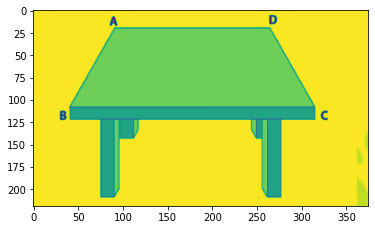

In [35]:
path = 'table.png'
img = cv2.imread(path)

print(img.shape)
gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
print(gray_image.shape)
plt.imshow(gray_image)

In [36]:
sigma = 0.5
size = 0.4#this one for sigma 1
#size = 0.3#for sigma 0.5
Gx, Gy = calculate_filter_size_gradient(0.3, sigma)

<class 'numpy.ndarray'>
[[0.77880078 0.53526143]
 [0.53526143 0.36787944]]
[[  794.   546.]
 [-1092.  -750.]]
[[  794. -1092.]
 [  546.  -750.]]


True

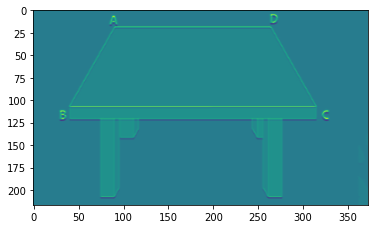

In [37]:
fx, fy = fx_fy_gradient(Gx, Gy, gray_image)
plt.imshow(fx)
cv2.imwrite('image/'+str(path)+'_fx'+str(sigma)+'.jpg', fx)

True

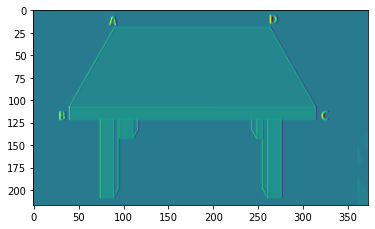

In [38]:
plt.imshow(fy)
cv2.imwrite('image/'+str(path)+'_fy'+str(sigma)+'.jpg', fy)

Calling the magnitude function

True

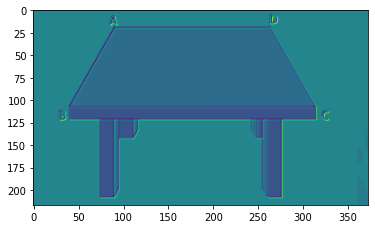

In [39]:
magnitude = magnitude(fx, fy)
plt.imshow(magnitude)
cv2.imwrite('image/'+str(path)+'_magnitude_'+str(sigma)+'.jpg', magnitude)

In [40]:
angles = direction(fx, fy)


[[-2.35619449 -2.35619449 -2.35619449 ... -2.35619449 -2.35619449
  -2.35619449]
 [-2.35619449 -2.35619449 -2.35619449 ... -2.35619449 -2.35619449
  -2.35619449]
 [-2.35619449 -2.35619449 -2.35619449 ... -2.35619449 -2.35619449
  -2.35619449]
 ...
 [-2.35619449 -2.35619449 -2.35619449 ... -2.35619449 -2.34910008
  -2.34919107]
 [-2.35619449 -2.35619449 -2.35619449 ... -2.3632889  -2.35619449
  -2.34231497]
 [-2.35619449 -2.35619449 -2.35619449 ... -2.3632889  -2.35619449
  -2.34935712]]
[[45.         45.         45.         ... 45.         45.
  45.        ]
 [45.         45.         45.         ... 45.         45.
  45.        ]
 [45.         45.         45.         ... 45.         45.
  45.        ]
 ...
 [45.         45.         45.         ... 45.         45.40647999
  45.40126625]
 [45.         45.         45.         ... 44.59352001 45.
  45.79523812]
 [45.         45.         45.         ... 44.59352001 45.
  45.39175255]]


True

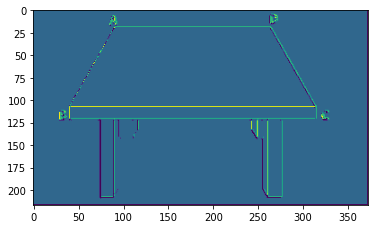

In [41]:
quantized_magnitude = quantization(magnitude, angles)
plt.imshow(quantized_magnitude)

colored = colored_quantization(quantized_magnitude, magnitude)
cv2.imwrite('image/'+str(path)+'_quantized_'+str(sigma)+'.jpg', colored)

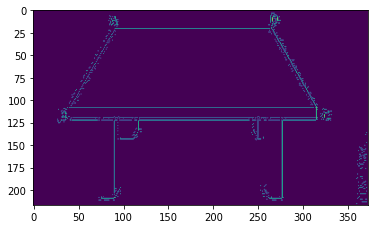

In [42]:
magnitudes = non_max_supression(magnitude, quantized_magnitude)
plt.imshow(magnitudes)

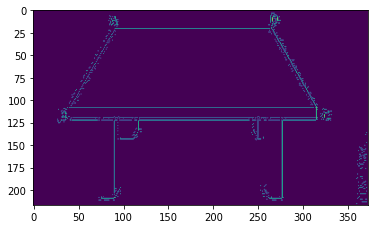

In [43]:
#th, tl = 400, 200 #for sigma 0.5
#th, tl = 1, 0.5#for sigma 1
th, tl = .25, 0.12
M = hysteresis_thresholding(th, tl, magnitudes)
plt.imshow(M)

In [44]:
print(M)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


True

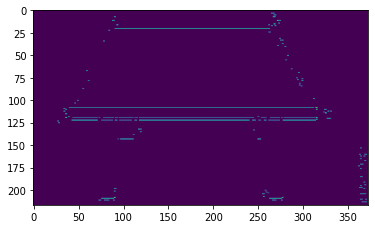

In [45]:
f = inbetween_values_check(M)
plt.imshow(f)
cv2.imwrite('image/'+str(path)+'_hysteresis_Th'+str(th)+'_Tl'+str(tl)+'_'+str(sigma)+'.jpg', f)

In [46]:
f

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])